# MIRNet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from pdb import set_trace as stx
import math

##########################################################################
##---------- Selective Kernel Feature Fusion (SKFF) ----------
class SKFF(nn.Module):
    def __init__(self, in_channels, height=3,reduction=8,bias=False):
        super(SKFF, self).__init__()
        
        self.height = height
        d = max(int(in_channels/reduction),4)
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(nn.Conv2d(in_channels, d, 1, padding=0, bias=bias), nn.LeakyReLU(0.2))

        self.fcs = nn.ModuleList([])
        for i in range(self.height):
            self.fcs.append(nn.Conv2d(d, in_channels, kernel_size=1, stride=1,bias=bias))
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inp_feats):
        batch_size = inp_feats[0].shape[0]
        n_feats =  inp_feats[0].shape[1]
        

        inp_feats = torch.cat(inp_feats, dim=1)
        inp_feats = inp_feats.view(batch_size, self.height, n_feats, inp_feats.shape[2], inp_feats.shape[3])
        
        feats_U = torch.sum(inp_feats, dim=1)
        feats_S = self.avg_pool(feats_U)
        feats_Z = self.conv_du(feats_S)

        attention_vectors = [fc(feats_Z) for fc in self.fcs]
        attention_vectors = torch.cat(attention_vectors, dim=1)
        attention_vectors = attention_vectors.view(batch_size, self.height, n_feats, 1, 1)
        # stx()
        attention_vectors = self.softmax(attention_vectors)
        
        feats_V = torch.sum(inp_feats*attention_vectors, dim=1)
        
        return feats_V        



class ContextBlock(nn.Module):

    def __init__(self, n_feat, bias=False):
        super(ContextBlock, self).__init__()

        self.conv_mask = nn.Conv2d(n_feat, 1, kernel_size=1, bias=bias)
        self.softmax = nn.Softmax(dim=2)

        self.channel_add_conv = nn.Sequential(
            nn.Conv2d(n_feat, n_feat, kernel_size=1, bias=bias),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_feat, n_feat, kernel_size=1, bias=bias)
        )

    def modeling(self, x):
        batch, channel, height, width = x.size()
        input_x = x
        # [N, C, H * W]
        input_x = input_x.view(batch, channel, height * width)
        # [N, 1, C, H * W]
        input_x = input_x.unsqueeze(1)
        # [N, 1, H, W]
        context_mask = self.conv_mask(x)
        # [N, 1, H * W]
        context_mask = context_mask.view(batch, 1, height * width)
        # [N, 1, H * W]
        context_mask = self.softmax(context_mask)
        # [N, 1, H * W, 1]
        context_mask = context_mask.unsqueeze(3)
        # [N, 1, C, 1]
        context = torch.matmul(input_x, context_mask)
        # [N, C, 1, 1]
        context = context.view(batch, channel, 1, 1)

        return context

    def forward(self, x):
        # [N, C, 1, 1]
        context = self.modeling(x)

        # [N, C, 1, 1]
        channel_add_term = self.channel_add_conv(context)
        x = x + channel_add_term

        return x

##########################################################################
### --------- Residual Context Block (RCB) ----------
class RCB(nn.Module):
    def __init__(self, n_feat, kernel_size=3, reduction=8, bias=False, groups=1):
        super(RCB, self).__init__()
        
        act = nn.LeakyReLU(0.2)

        self.body = nn.Sequential(
            nn.Conv2d(n_feat, n_feat, kernel_size=3, stride=1, padding=1, bias=bias, groups=groups),
            act, 
            nn.Conv2d(n_feat, n_feat, kernel_size=3, stride=1, padding=1, bias=bias, groups=groups)
        )

        self.act = act
        
        self.gcnet = ContextBlock(n_feat, bias=bias)

    def forward(self, x):
        res = self.body(x)
        res = self.act(self.gcnet(res))
        res += x
        return res


##########################################################################
##---------- Resizing Modules ----------    
class Down(nn.Module):
    def __init__(self, in_channels, chan_factor, bias=False):
        super(Down, self).__init__()

        self.bot = nn.Sequential(
            nn.AvgPool2d(2, ceil_mode=True, count_include_pad=False),
            nn.Conv2d(in_channels, int(in_channels*chan_factor), 1, stride=1, padding=0, bias=bias)
            )

    def forward(self, x):
        return self.bot(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, scale_factor, chan_factor=2, kernel_size=3):
        super(DownSample, self).__init__()
        self.scale_factor = int(np.log2(scale_factor))

        modules_body = []
        for i in range(self.scale_factor):
            modules_body.append(Down(in_channels, chan_factor))
            in_channels = int(in_channels * chan_factor)
        
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        x = self.body(x)
        return x

class Up(nn.Module):
    def __init__(self, in_channels, chan_factor, bias=False):
        super(Up, self).__init__()

        self.bot = nn.Sequential(
            nn.Conv2d(in_channels, int(in_channels//chan_factor), 1, stride=1, padding=0, bias=bias),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=bias)
            )

    def forward(self, x):
        return self.bot(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, scale_factor, chan_factor=2, kernel_size=3):
        super(UpSample, self).__init__()
        self.scale_factor = int(np.log2(scale_factor))

        modules_body = []
        for i in range(self.scale_factor):
            modules_body.append(Up(in_channels, chan_factor))
            in_channels = int(in_channels // chan_factor)
        
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        x = self.body(x)
        return x


##########################################################################
##---------- Multi-Scale Resiudal Block (MRB) ----------
class MRB(nn.Module):
    def __init__(self, n_feat, height, width, chan_factor, bias,groups):
        super(MRB, self).__init__()

        self.n_feat, self.height, self.width = n_feat, height, width
        
        self.dau_top = RCB(int(n_feat*chan_factor**0), bias=bias, groups=groups)
        self.dau_mid = RCB(int(n_feat*chan_factor**1), bias=bias, groups=groups)
        self.dau_bot = RCB(int(n_feat*chan_factor**2), bias=bias, groups=groups)

        self.down2 = DownSample(int((chan_factor**0)*n_feat),2,chan_factor)
        self.down4 = nn.Sequential(
            DownSample(int((chan_factor**0)*n_feat),2,chan_factor), 
            DownSample(int((chan_factor**1)*n_feat),2,chan_factor)
        )

        self.up21_1 = UpSample(int((chan_factor**1)*n_feat),2,chan_factor)
        self.up21_2 = UpSample(int((chan_factor**1)*n_feat),2,chan_factor)
        self.up32_1 = UpSample(int((chan_factor**2)*n_feat),2,chan_factor)
        self.up32_2 = UpSample(int((chan_factor**2)*n_feat),2,chan_factor)

        self.conv_out = nn.Conv2d(n_feat, n_feat, kernel_size=1, padding=0, bias=bias)

        # only two inputs for SKFF
        self.skff_top = SKFF(int(n_feat*chan_factor**0), 2)
        self.skff_mid = SKFF(int(n_feat*chan_factor**1), 2)

    def forward(self, x):
        x_top = x.clone()
        x_mid = self.down2(x_top)
        x_bot = self.down4(x_top)

        x_top = self.dau_top(x_top)
        x_mid = self.dau_mid(x_mid)
        x_bot = self.dau_bot(x_bot)

        x_mid = self.skff_mid([x_mid, self.up32_1(x_bot)])
        x_top = self.skff_top([x_top, self.up21_1(x_mid)])

        x_top = self.dau_top(x_top)
        x_mid = self.dau_mid(x_mid)
        x_bot = self.dau_bot(x_bot)

        x_mid = self.skff_mid([x_mid, self.up32_2(x_bot)])
        x_top = self.skff_top([x_top, self.up21_2(x_mid)])

        out = self.conv_out(x_top)
        out = out + x

        return out

##########################################################################
##---------- Recursive Residual Group (RRG) ----------
class RRG(nn.Module):
    def __init__(self, n_feat, n_MRB, height, width, chan_factor, bias=False, groups=1):
        super(RRG, self).__init__()
        modules_body = [MRB(n_feat, height, width, chan_factor, bias, groups) for _ in range(n_MRB)]
        modules_body.append(nn.Conv2d(n_feat, n_feat, kernel_size=3, stride=1, padding=1, bias=bias))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res


##########################################################################
##---------- MIRNet  -----------------------
class MIRNet_v2(nn.Module):
    def __init__(self,
        inp_channels=3,
        out_channels=3,
        n_feat=80,
        chan_factor=1.5,
        n_RRG=4,
        n_MRB=2,
        height=3,
        width=2,
        scale=1,
        bias=False,
        task= None
    ):
        super(MIRNet_v2, self).__init__()

        kernel_size=3
        self.task = task

        self.conv_in = nn.Conv2d(inp_channels, n_feat, kernel_size=3, padding=1, bias=bias)

        modules_body = []
        
        modules_body.append(RRG(n_feat, n_MRB, height, width, chan_factor, bias, groups=1))
        
        modules_body.append(RRG(n_feat, n_MRB, height, width, chan_factor, bias, groups=2))
        modules_body.append(RRG(n_feat, n_MRB, height, width, chan_factor, bias, groups=4))
        modules_body.append(RRG(n_feat, n_MRB, height, width, chan_factor, bias, groups=4))

        self.body = nn.Sequential(*modules_body)
        self.conv_out = nn.Conv2d(n_feat, out_channels, kernel_size=3, padding=1, bias=bias)
        

    def forward(self, inp_img):
        shallow_feats = self.conv_in(inp_img)
        deep_feats = self.body(shallow_feats)

        if self.task == 'defocus_deblurring':
            deep_feats += shallow_feats
            out_img = self.conv_out(deep_feats)

        else:
            out_img = self.conv_out(deep_feats)
            out_img += inp_img

        return out_img


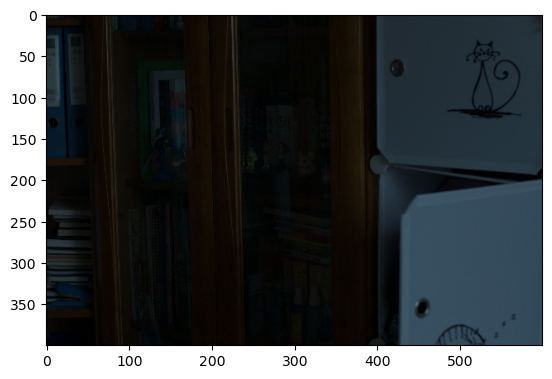

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('./low/1.png')
plt.imshow(img)

In [44]:
import torchvision.transforms as transforms
transform = transforms.ToTensor()
x = transform(img)
x = x.unsqueeze(0)
x_input = x
x.shape

torch.Size([1, 3, 400, 600])

# 0. 整体流程

Conv 4个RRG Conv 再将得到结果和原输入相加

每个RRG在这篇文章里是2个MRB

每个MRB再拆分成一个multi-scale的fusion 和叠加

## 1. Conv_in



In [12]:
conv_in = nn.Conv2d(3,80, kernel_size=3, padding=1, bias=False)
x = conv_in(x)
x.shape

torch.Size([1, 80, 400, 600])

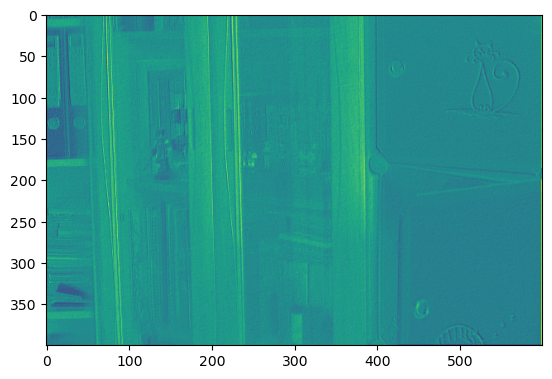

In [16]:
plt.imshow(x[0][0].detach().numpy())

## 2. RRG 以及拆分流程

In [13]:
rrg = RRG(80, 2, 3, 2, 1.5, False, groups=1)
x_rrg = rrg(x)
x_rrg.shape

torch.Size([1, 80, 400, 600])

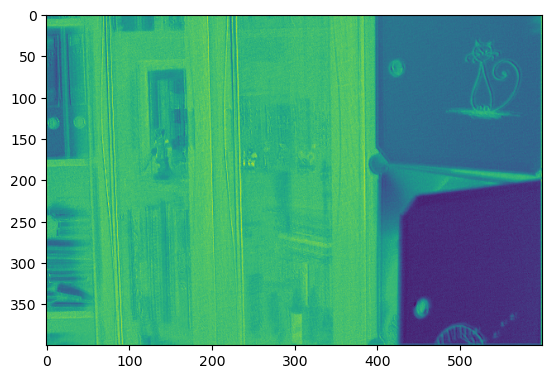

In [15]:
plt.imshow(x_rrg[0][0].detach().numpy())

### 2.1 MRB
一个RRG = 2 次MRB + 1 Conv2d

In [17]:
mrb = MRB(80, 3, 2, 1.5, False, groups = 1)
x_mrb = mrb(x)
x_mrb.shape

torch.Size([1, 80, 400, 600])

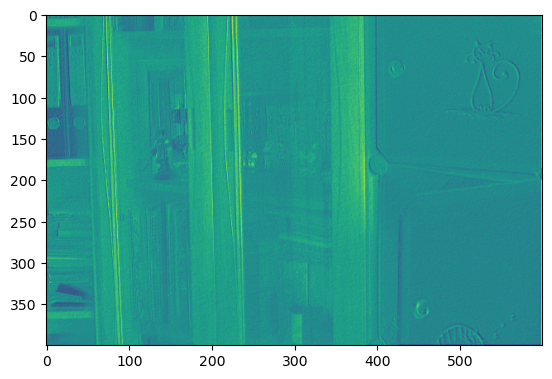

In [21]:
plt.imshow(x_mrb[0][0].detach().numpy())

In [23]:
x_mrb2 = mrb(x_mrb)
conv_mrb = nn.Conv2d(80, 80, kernel_size=3, stride=1, padding=1, bias = False)
res_mrb = conv_mrb(x_mrb2) + x_mrb
res_mrb.shape

torch.Size([1, 80, 400, 600])

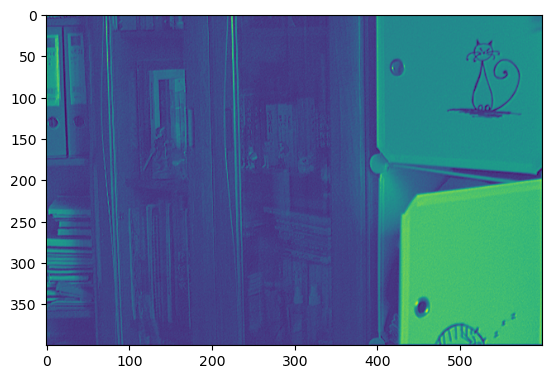

In [25]:
plt.imshow(res_mrb[0][6].detach().numpy())

#### 2.1.1 MRB 内部

有RCB和SKFF

In [27]:
# RCB
rcb = RCB(int(80*1.5**1), bias=False, groups=1)
ds = DownSample(int((1.5**0)*80),2,1.5)
x_mid = rcb(ds(x))
x_mid.shape

torch.Size([1, 120, 200, 300])

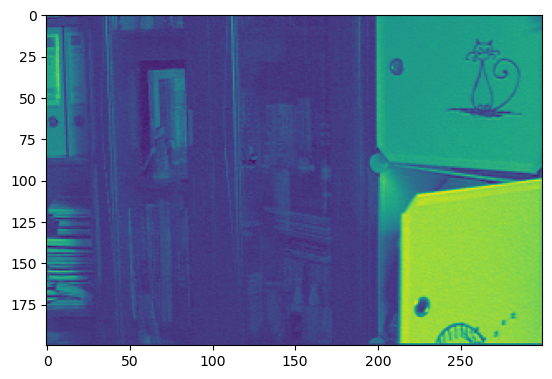

In [28]:
plt.imshow(x_mid[0][0].detach().numpy())

## 3. 多个RGG


In [37]:
rrg2 = RRG(80, 2, 3, 2, 1.5, False, groups=2)
rrg4 = RRG(80, 2, 3, 2, 1.5, False, groups=4)
x_rrg2 = rrg2(x_rrg)
x_rrg2.shape

torch.Size([1, 80, 400, 600])

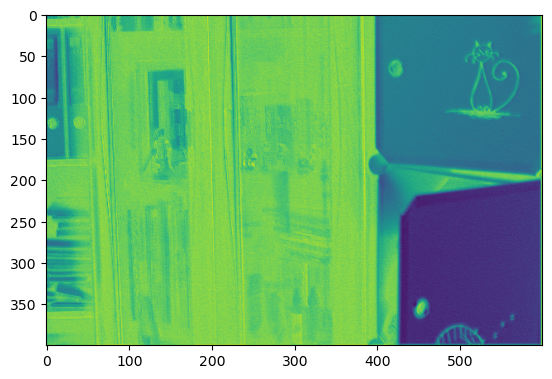

In [30]:
plt.imshow(x_rrg2[0][0].detach().numpy())

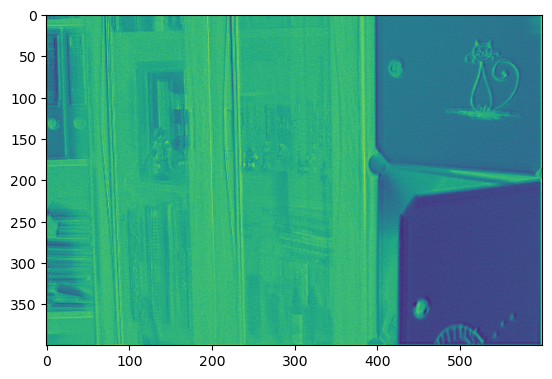

In [31]:
x_rrg3 = rrg4(x_rrg2)
plt.imshow(x_rrg3[0][0].detach().numpy())

torch.Size([1, 80, 400, 600])


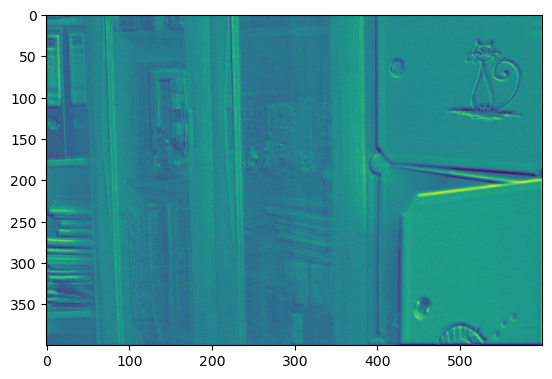

In [39]:
x_rrg4 = rrg4(x_rrg3)
print(x_rrg4.shape)
plt.imshow(x_rrg4[0][0].detach().numpy())

## 4. Conv_out

torch.Size([1, 3, 400, 600])


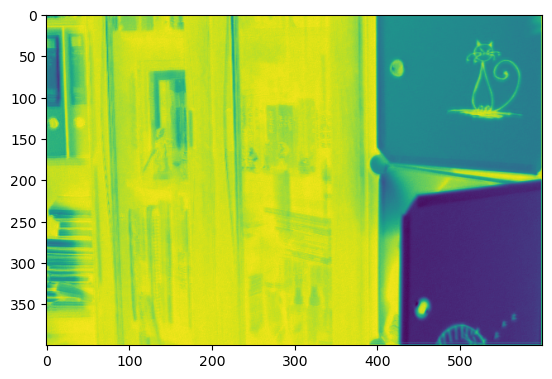

In [55]:
conv_out = nn.Conv2d(80, 3, kernel_size=3, padding=1, bias=False)
x_out = conv_out(x_rrg4)
print(x_out.shape)
plt.imshow(x_out[0][0].detach().numpy())

In [56]:
x_out = x_input + x_out
print(x_out.shape)



torch.Size([1, 3, 400, 600])


In [73]:
x_out2 = (x_out.detach().numpy()*255).astype(np.uint8)[0]

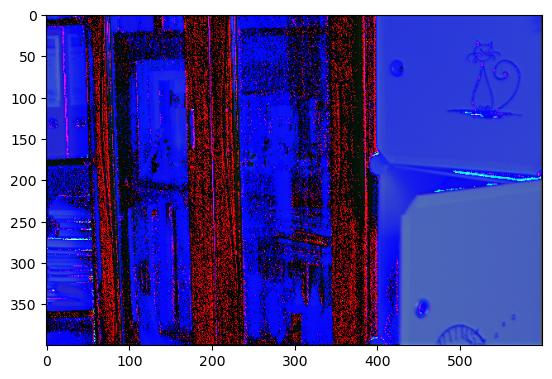

In [82]:
import cv2
r = x_out2[0]
g = x_out2[1]
b = x_out2[2]
plt.imshow(cv2.merge([b,g,r]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


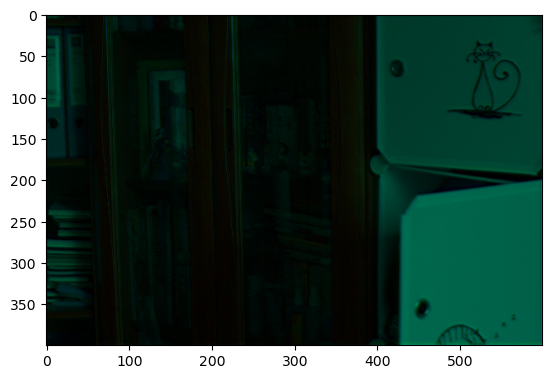

In [87]:
plt.imshow(x_out[0].detach().permute(1,2,0).numpy())

In [83]:
mir = MIRNet_v2()
x_mir = mir(x)
x_mir.shape

torch.Size([1, 3, 400, 600])

In [84]:
x_mir


tensor([[[[0.0440, 0.1095, 0.1224,  ..., 0.1213, 0.1257, 0.1396],
          [0.0549, 0.1279, 0.1383,  ..., 0.1416, 0.1605, 0.1839],
          [0.1236, 0.1967, 0.1791,  ..., 0.1870, 0.2080, 0.1680],
          ...,
          [0.0049, 0.0127, 0.0168,  ..., 0.3753, 0.4088, 0.3634],
          [0.0099, 0.0299, 0.0250,  ..., 0.4714, 0.5194, 0.4255],
          [0.0114, 0.0078, 0.0085,  ..., 0.3510, 0.4138, 0.2842]],

         [[0.1920, 0.2045, 0.2075,  ..., 0.1803, 0.1632, 0.1015],
          [0.2439, 0.2909, 0.2941,  ..., 0.2462, 0.2058, 0.1392],
          [0.3081, 0.3090, 0.3345,  ..., 0.2529, 0.2245, 0.1361],
          ...,
          [0.0388, 0.0416, 0.0360,  ..., 0.5755, 0.4744, 0.3194],
          [0.0458, 0.0531, 0.0391,  ..., 0.5934, 0.5240, 0.3636],
          [0.0209, 0.0254, 0.0188,  ..., 0.3739, 0.2965, 0.3448]],

         [[0.1607, 0.2138, 0.1879,  ..., 0.1445, 0.1791, 0.1457],
          [0.2059, 0.2376, 0.2465,  ..., 0.2154, 0.2339, 0.2249],
          [0.2146, 0.2603, 0.2817,  ..., 0

# 1. LLFormer

In [102]:
import numbers
from einops import rearrange

import torch
import torch.nn as nn
import torch.nn.functional as F
from pdb import set_trace as stx
import numbers

import einops
class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type =='BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)
class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma+1e-5) * self.weight + self.bias
class NextAttentionImplZ(nn.Module):
    def __init__(self, num_dims, num_heads, bias) -> None:
        super().__init__()
        self.num_dims = num_dims
        self.num_heads = num_heads
        self.q1 = nn.Conv2d(num_dims, num_dims * 3, kernel_size=1, bias=bias)
        self.q2 = nn.Conv2d(num_dims * 3, num_dims * 3, kernel_size=3, padding=1, groups=num_dims * 3, bias=bias)
        self.q3 = nn.Conv2d(num_dims * 3, num_dims * 3, kernel_size=3, padding=1, groups=num_dims * 3, bias=bias)

        self.fac = nn.Parameter(torch.ones(1))
        self.fin = nn.Conv2d(num_dims, num_dims, kernel_size=1, bias=bias)
        return

    def forward(self, x):
        # x: [n, c, h, w]
        n, c, h, w = x.size()
        n_heads, dim_head = self.num_heads, c // self.num_heads
        reshape = lambda x: einops.rearrange(x, "n (nh dh) h w -> (n nh h) w dh", nh=n_heads, dh=dim_head)

        qkv = self.q3(self.q2(self.q1(x)))
        q, k, v = map(reshape, qkv.chunk(3, dim=1))
        q = F.normalize(q, dim=-1)
        k = F.normalize(k, dim=-1)

        # fac = dim_head ** -0.5
        res = k.transpose(-2, -1)
        res = torch.matmul(q, res) * self.fac
        res = torch.softmax(res, dim=-1)

        res = torch.matmul(res, v)
        res = einops.rearrange(res, "(n nh h) w dh -> n (nh dh) h w", nh=n_heads, dh=dim_head, n=n, h=h)
        res = self.fin(res)

        return res

    
    ###### Dual Gated Feed-Forward Networ
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FeedForward, self).__init__()

        hidden_features = int(dim*ffn_expansion_factor)

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias)

        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = F.gelu(x2)*x1 + F.gelu(x1)*x2
        x = self.project_out(x)
        return x
    
### Axis-based Multi-head Self-Attention (row and col attention)
class NextAttentionZ(nn.Module):
    def __init__(self, num_dims, num_heads=1, bias=True) -> None:
        super().__init__()
        assert num_dims % num_heads == 0
        self.num_dims = num_dims
        self.num_heads = num_heads
        self.row_att = NextAttentionImplZ(num_dims, num_heads, bias)
        self.col_att = NextAttentionImplZ(num_dims, num_heads, bias)
        return

    def forward(self, x: torch.Tensor):
        assert len(x.size()) == 4

        x = self.row_att(x)
        x = x.transpose(-2, -1)
        x = self.col_att(x)
        x = x.transpose(-2, -1)

        return x
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=1, ffn_expansion_factor=2.66, bias=True, LayerNorm_type='WithBias'):
        super(TransformerBlock, self).__init__()

        self.norm1 = LayerNorm(dim, LayerNorm_type)
        self.attn = NextAttentionZ(dim, num_heads)
        # self.s2a = S2Attention(channels = dim)
        # self.shuffleAttn = ShuffleAttention(channel = dim)

        self.norm2 = LayerNorm(dim, LayerNorm_type)
        self.ffn = FeedForward(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        # x = x + self.s2a(self.norm1(x))
        
        # x = x + self.cbam(self.norm1(x))
        # x = x + self.shuffleAttn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x
    
def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x,h,w):
    return rearrange(x, 'b (h w) c -> b c h w',h=h,w=w)
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c=3, embed_dim=48, bias=False):
        super(OverlapPatchEmbed, self).__init__()

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, x):
        x = self.proj(x)

        return x

In [104]:
tb = TransformerBlock(16, 2, bias = False)
OPE = OverlapPatchEmbed(3, 16) #把输入从3转到16，然后才和transformer的in_dim 匹配
outs = tb(OPE(x_input))

In [105]:
outs.shape

torch.Size([1, 16, 400, 600])